In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import missingno as msno
from library.sb_utils import save_file

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [203]:
DM_data = pd.read_csv('../raw_data/diabetic_data.csv')

In [204]:
#DM_data.info()
DM_data.shape

(101766, 50)

In [205]:
#DM_data.isnull().sum()

In [206]:
#checking data types, we see age is "object" instead of int or float. But, our source data has age in rangeof numbers
#instead of single values. However, we need to replace the '[]', '()' from the values

In [207]:
DM_data['age'] = DM_data['age'].str.replace('[','').str.replace(')','')

In [208]:
DM_data.head(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0-10,?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,10-20,?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30


In [209]:
DM_data['weight'].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [210]:
#There is no missing value in our data but upon observing the weight column, 97% of its values are '?', 
#so I will drop weight column. But before that, I will try to find if other columns have '?' as well.

In [211]:
columns_with_questionmark = []
for col in DM_data.columns: 
    if '?' in DM_data[col].values:
        columns_with_questionmark.append(col)    
print(columns_with_questionmark)    

['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


In [212]:
#calculating percentage of '?' values in columns where it is found.
col_names = ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']
cols = {}
for col in col_names:
    length = len(DM_data[DM_data[col] == '?'])
    per = length / DM_data.shape[0] * 100
    cols[col] = per
#print(cols)  
df = pd.DataFrame(cols.items(), columns = ['column_name', '% of \" ?\"'])
df.sort_values(by = '% of \" ?\"', ascending=False)

,column_name,"% of "" ?"""
1,weight,96.858479
3,medical_specialty,49.082208
2,payer_code,39.557416
0,race,2.233555
6,diag_3,1.398306
5,diag_2,0.351787
4,diag_1,0.020636


In [213]:
#Here we see "payer_code", "medical_specialty", and  "weight" have more than 39% of their values as "?".
#So I drop those columns

In [214]:
DM_data.drop(['payer_code','medical_specialty', 'weight'], axis =1,inplace=True)

In [215]:
#DM_data.shape

In [216]:
#Next, I replaced the "?", in the rest of data with np.nan so we can better visualize missing values and correlation among 
#other missing values using missingno package

In [217]:
DM_data = DM_data.replace('?', np.nan)
#DM_data.head()

In [218]:
#msno.bar(DM_data)

In [219]:
#msno.matrix(DM_data)

In [220]:
#msno.heatmap(DM_data)

In [221]:
#The missing values do not seem to have strong correlations, though diag_2 and 3 seem to have slight corr.

In [222]:
#msno.dendrogram(DM_data)

In [223]:
#From the missing data values, we see that diag_1, 2 and 3 and "race" have missing values. These missing values seem 
#to follow missing at completely random pattern (MCAR), as each do not seem to be correlated with each other and there are 
#few of them.I will drop them.

In [224]:
missing = DM_data[['race','diag_1','diag_2','diag_3']].isnull().sum()*100 /len(DM_data)
missing_Df = pd.DataFrame({'% of missing': missing}).sort_values('% of missing', ascending=False)
missing_Df

,% of missing
race,2.233555
diag_3,1.398306
diag_2,0.351787
diag_1,0.020636


In [225]:
DM_data.shape

(101766, 47)

In [226]:
DM = DM_data.dropna()

In [227]:
DM.shape

(98053, 47)

In [228]:
 #DM['A1Cresult'].value_counts().to_frame()

In [229]:
DM['examide'].value_counts(normalize=True).loc[lambda x: x >0.8] # in more than 80% cases, this drug was not given

No    1.0
Name: examide, dtype: float64

In [230]:
#Actually none of the patients were given examide.

In [231]:
DM['examide'].value_counts().to_frame()

,examide
No,98053


In [232]:
DM['insulin'].value_counts(normalize=True)

No        0.468553
Steady    0.299511
Down      0.120782
Up        0.111154
Name: insulin, dtype: float64

In [233]:
# meds_cols = DM.columns[21:44]  #selecting the features of the medications/drugs
# meds_cols

In [234]:
# drugs_not_given_inmorethan_80 = []
# for col in meds_cols:
#     drugs_not_given_inmorethan_80.append(DM[col].value_counts(normalize=True).loc[lambda x: x > 0.8].to_frame())
# #drugs_not_given_inmorethan_80

In [235]:
#Drugs such as metformin-pioglitazone,examide and citoglipton were not given to any patient. In fact, except metformin,  
#which was given,kept steady or changed dosage to ~20% of patients, and insulin ( to ~53%), most drugs were not given to 
#99% of patients. These features' variance is low to help us in our work. However, I will keep those that were given to at 
#least 87% of patients and drop the rest. We might get something interesting patterns when we visualize these against our 
#target value. 

In [236]:
#Insulin was adminstered to about 53% of the patients. Now, let's find out if the rest of the patients that 
#did not get insulin (47%),received something or nothing while at the hospital.

In [237]:
# DM_drugs = DM[['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
#        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
#        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
#        'tolazamide', 'examide', 'citoglipton', 'insulin',
#        'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone']]
# DM_drugs.head()

In [238]:
# Du = DM_drugs.replace(['No', 'Up'], [0,1])
# Dd = Du.replace(['No', 'Down'], [0,1])
# Ds = Dd.replace(['No', 'Steady'], [0,1])
# Ds.head()

In [239]:
# Ds['sum'] = Ds.sum(axis=1)
# Ds.head()

In [240]:
# Ds['sum'].value_counts()

In [241]:
#Here we can see 22,702 patients did not receive any drug ( assuming there all are unique for now)

In [242]:
# DM_ones = Ds[Ds['sum'] == 1]
# DM_ones.head()
#DM_repeat_patients[['patient_nbr','race']].shape

In [243]:
# DM_ones.sum()

In [244]:
#Earlier I found metformin-rosiglitazone, citoglipton, examide with normalized value_counts value of 1 for "No" which meant
#those drugs were not adminstered at all. This is consistent with the normalized value_count result. However, when summing 
#along columns and rows of our DM_ones df,glimepiride-pioglitazone, metformin-pioglitazone,troglitazone,acetohexamide came out
#to be 0. Let's see unique value_counts of these four.

In [245]:
# print(DM_drugs['glimepiride-pioglitazone'].value_counts().to_frame())
# print(DM_drugs['metformin-pioglitazone'].value_counts().to_frame())
# print(DM_drugs['troglitazone'].value_counts().to_frame())
# print(DM_drugs['acetohexamide'].value_counts().to_frame())

In [246]:
#We can drop the drugs that were never adminstered. Moreover, I will experiment later on if dropping the drugs that were kept 
#steady only once makes difference in my model.

In [247]:
# acet = DM_drugs[DM_drugs['acetohexamide'] == 'Steady']  #eg, acetohexamide was kept steady along with insulin.
# acet

In [248]:
DM.drop(['metformin-rosiglitazone','citoglipton', 'examide'], axis =1,inplace=True)

#DM_repeat_patients1 = DM_repeat_patients.sort_values('patient_nbr').drop_duplicates('patient_nbr', keep='last')

C:\Users\14322\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [249]:
DM.shape
DM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98053 entries, 1 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              98053 non-null  int64 
 1   patient_nbr               98053 non-null  int64 
 2   race                      98053 non-null  object
 3   gender                    98053 non-null  object
 4   age                       98053 non-null  object
 5   admission_type_id         98053 non-null  int64 
 6   discharge_disposition_id  98053 non-null  int64 
 7   admission_source_id       98053 non-null  int64 
 8   time_in_hospital          98053 non-null  int64 
 9   num_lab_procedures        98053 non-null  int64 
 10  num_procedures            98053 non-null  int64 
 11  num_medications           98053 non-null  int64 
 12  number_outpatient         98053 non-null  int64 
 13  number_emergency          98053 non-null  int64 
 14  number_inpatient     

In [250]:
#The other two columns I want to investigate are max_glu_serum and A1Cresult as their values are dominated by 
# 'None',which means these measurements were not taken on the patients.

In [251]:
DM['A1Cresult'].value_counts(normalize=True).to_frame()

,A1Cresult
None,0.834855
>8,0.077825
Norm,0.049504
>7,0.037816


In [252]:
DM['max_glu_serum'].value_counts(normalize=True).to_frame()

,max_glu_serum
None,0.946886
Norm,0.025823
>200,0.014778
>300,0.012514


In [253]:
#DM['number_inpatient'].value_counts().to_frame()

In [254]:
DM['encounter_id'].nunique()

98053

In [255]:
DM['patient_nbr'].nunique()

68630

In [256]:
#Here I see that encounter_id matches the number of rows we have in our df, however, patient_nbr does not and it is lower.
#This indicates there were patients that had multiple hospital visits.

In [257]:
DM_epr = DM[['encounter_id','patient_nbr','race']]
DM_epr.head()

,encounter_id,patient_nbr,race
1,149190,55629189,Caucasian
2,64410,86047875,AfricanAmerican
3,500364,82442376,Caucasian
4,16680,42519267,Caucasian
5,35754,82637451,Caucasian


In [258]:
patient = DM_epr.groupby('patient_nbr').count()
patient.head()

,encounter_id,race
patient_nbr,,
135,2,2
378,1,1
729,1,1
774,1,1
927,1,1


In [259]:
#Above, we can see that for instance, patient_nbr 135 has two encounter_ids, meaning couple of visits.I will filter out the 
#ones with multiple visits and analyze the data for cleaness.

In [260]:
DM_epr[DM_epr['patient_nbr'] == 328887] #eg, this patient with patient_nbr 103140 had 13 visits in this df.

,encounter_id,patient_nbr,race
918,7062552,328887,Caucasian
2027,13067634,328887,Caucasian
2755,17701176,328887,Caucasian
3642,22086186,328887,Caucasian
8463,38243124,328887,Caucasian
10340,43891170,328887,Caucasian
12331,50281458,328887,Caucasian
13741,54260868,328887,Caucasian


In [261]:
repeat_patients = patient[patient['encounter_id'] != 1]
repeat_patients.head()
#DM_repeat_patients = DM_repeat_patients[DM_repeat_patients['patient_nbr'].isin(DM_repeat_patients['patient_nbr'].unique())]

,encounter_id,race
patient_nbr,,
135,2,2
1152,3,3
1314,3,3
5220,4,4
5337,2,2


In [262]:
repeat_patients.sum()
#DM_repeat_patients.head()

encounter_id    45703
race            45703
dtype: int64

In [263]:
DM_epr.head()  

,encounter_id,patient_nbr,race
1,149190,55629189,Caucasian
2,64410,86047875,AfricanAmerican
3,500364,82442376,Caucasian
4,16680,42519267,Caucasian
5,35754,82637451,Caucasian


In [264]:
repeat_p = DM_epr[DM_epr['patient_nbr'].isin(repeat_patients.index)]
repeat_p.head()

,encounter_id,patient_nbr,race
12,40926,85504905,Caucasian
27,248916,115196778,Caucasian
28,250872,41606064,Caucasian
32,260166,80845353,Caucasian
33,293058,114715242,Caucasian


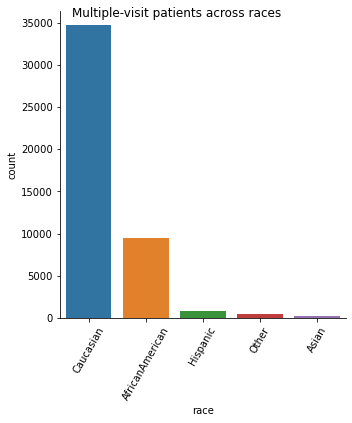

In [265]:
races = ['Caucasian', 'AfricanAmerican', 'Hispanic', 'Other','Asian']
g = sns.catplot(x='race', kind='count', data=repeat_p, order=races)
g.fig.suptitle('Multiple-visit patients across races')
plt.xticks(rotation=60)

plt.show()

In [266]:
DM['readmitted'].value_counts()

NO     52338
>30    34649
<30    11066
Name: readmitted, dtype: int64

In [267]:
DM['readmitted'] = DM['readmitted'].replace(regex={r'.\d\d':'Yes', 'NO':'No'})

C:\Users\14322\AppData\Local\Temp/ipykernel_3804/195267735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DM['readmitted'] = DM['readmitted'].replace(regex={r'.\d\d':'Yes', 'NO':'No'})


In [268]:
DM.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,10-20,1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,Yes
2,64410,86047875,AfricanAmerican,Female,20-30,1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No
3,500364,82442376,Caucasian,Male,30-40,1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,No
4,16680,42519267,Caucasian,Male,40-50,1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Ch,Yes,No
5,35754,82637451,Caucasian,Male,50-60,2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes,Yes


In [272]:
DM['diabetesMed'].value_counts()

Yes    75351
No     22702
Name: diabetesMed, dtype: int64

In [274]:
DM['readmitted'].value_counts()

No     52338
Yes    45715
Name: readmitted, dtype: int64

In [270]:
#Here we see that in the 22702 encounters, no diabetic medications were adminstered. We were already able to see 
#this earlier. This column along with "change" column is just information repetition, which may not help our 
#prediction model.

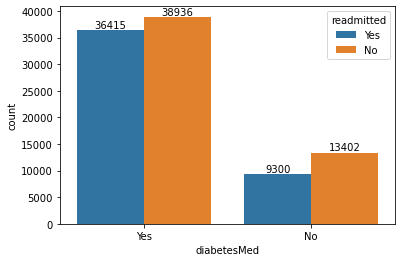

In [279]:
g = sns.countplot(x= 'diabetesMed', data= DM, hue= 'readmitted')
for cont in g.containers:
    g.bar_label(cont)

In [280]:
#In the encounters with patients with medication, ~48% of those were readmitted in less or greater than 30 days.
#Whereas in the encounters with patients with no medication, ~41% were readmitted in less or greater than 30 days.